# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1320s3"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.jpg')
x_data = []
y_data = []

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = int(target)
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1582, 32, 20, 3)
(1582, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 32)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
396/396 [==============================] - 4s 9ms/step - loss: 2.2329 - accuracy: 0.3049
Epoch 2/500
396/396 [==============================] - 4s 9ms/step - loss: 1.5872 - accuracy: 0.4925
Epoch 3/500
396/396 [==============================] - 4s 9ms/step - loss: 1.1866 - accuracy: 0.6364
Epoch 4/500
396/396 [==============================] - 4s 10ms/step - loss: 0.9064 - accuracy: 0.7150 0s - loss: 0.9015 - accu - ETA: 0s - loss: 0.9
Epoch 5/500
396/396 [==============================] - 4s 9ms/step - loss: 0.8126 - accuracy: 0.7514
Epoch 6/500
396/396 [==============================] - 4s 10ms/step - loss: 0.7128 - accuracy: 0.7697 1s - l
Epoch 7/500
396/396 [==============================] - 4s 11ms/step - loss: 0.6657 - accuracy: 0.8073
Epoch 8/500
396/396 [==============================] - 4s 10ms/step - loss: 0.6313 - accuracy: 0.8061
Epoch 9/500
396/396 [==============================] - 4s 10ms/step - loss: 0.6305 - accuracy: 0.8042
Epoch 10/500
396/396 [==========

396/396 [==============================] - 4s 9ms/step - loss: 0.1872 - accuracy: 0.9440
Epoch 79/500
396/396 [==============================] - 4s 9ms/step - loss: 0.1380 - accuracy: 0.9566
Epoch 80/500
396/396 [==============================] - 4s 9ms/step - loss: 0.2197 - accuracy: 0.9463
Epoch 81/500
396/396 [==============================] - 3s 9ms/step - loss: 0.1918 - accuracy: 0.9487
Epoch 82/500
396/396 [==============================] - 4s 9ms/step - loss: 0.1553 - accuracy: 0.9462
Epoch 83/500
396/396 [==============================] - 4s 9ms/step - loss: 0.2009 - accuracy: 0.9465
Epoch 84/500
396/396 [==============================] - 4s 9ms/step - loss: 0.1432 - accuracy: 0.9600
Epoch 85/500
396/396 [==============================] - 4s 9ms/step - loss: 0.1475 - accuracy: 0.9488
Epoch 86/500
396/396 [==============================] - 4s 9ms/step - loss: 0.1692 - accuracy: 0.9413
Epoch 87/500
396/396 [==============================] - 4s 9ms/step - loss: 0.1050 - accuracy: 

396/396 [==============================] - 4s 10ms/step - loss: 0.0819 - accuracy: 0.9716
Epoch 157/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0833 - accuracy: 0.9717
Epoch 158/500
396/396 [==============================] - 4s 11ms/step - loss: 0.1273 - accuracy: 0.9624
Epoch 159/500
396/396 [==============================] - 4s 10ms/step - loss: 0.1084 - accuracy: 0.9749
Epoch 160/500
396/396 [==============================] - 4s 10ms/step - loss: 0.1275 - accuracy: 0.9675
Epoch 161/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0655 - accuracy: 0.9744
Epoch 162/500
396/396 [==============================] - 4s 10ms/step - loss: 0.1273 - accuracy: 0.9639
Epoch 163/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0974 - accuracy: 0.9660
Epoch 164/500
396/396 [==============================] - 4s 10ms/step - loss: 0.1180 - accuracy: 0.9722
Epoch 165/500
396/396 [==============================] - 4s 10ms/step - loss: 

396/396 [==============================] - 5s 12ms/step - loss: 0.0751 - accuracy: 0.9828
Epoch 255/500
396/396 [==============================] - 5s 13ms/step - loss: 0.0821 - accuracy: 0.9735 0s - loss: 0.0809 - accuracy: 0. - ETA: 0s - loss:
Epoch 256/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0577 - accuracy: 0.9840 0s - loss:
Epoch 257/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0777 - accuracy: 0.9788
Epoch 258/500
396/396 [==============================] - 4s 10ms/step - loss: 0.1004 - accuracy: 0.9737
Epoch 259/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0855 - accuracy: 0.9726
Epoch 260/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0619 - accuracy: 0.9768
Epoch 261/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0859 - accuracy: 0.9764
Epoch 262/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0646 - accuracy: 0.9850
Epoch 263/500
39

396/396 [==============================] - 4s 10ms/step - loss: 0.0505 - accuracy: 0.9827 0s - loss: 0.0474 - accuracy: 0.98 - ETA: 0s - loss: 0.0476 
Epoch 348/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0399 - accuracy: 0.9810
Epoch 349/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0864 - accuracy: 0.9778
Epoch 350/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0980 - accuracy: 0.9703
Epoch 351/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0849 - accuracy: 0.9698: 0s - loss: 0.0852 - ac
Epoch 352/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0556 - accuracy: 0.9859
Epoch 353/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0697 - accuracy: 0.9790
Epoch 354/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0663 - accuracy: 0.9815
Epoch 355/500
396/396 [==============================] - 3s 9ms/step - loss: 0.0603 - accuracy: 0.9790 

396/396 [==============================] - 4s 10ms/step - loss: 0.0633 - accuracy: 0.9809
Epoch 448/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0587 - accuracy: 0.9807
Epoch 449/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0513 - accuracy: 0.9868
Epoch 450/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0654 - accuracy: 0.9756
Epoch 451/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0558 - accuracy: 0.9846 0s - loss: 0.0554 - accuracy: 0.
Epoch 452/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0533 - accuracy: 0.9861
Epoch 453/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0523 - accuracy: 0.9870
Epoch 454/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0679 - accuracy: 0.9815
Epoch 455/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0570 - accuracy: 0.9839
Epoch 456/500
396/396 [========================

### Learing result
 
* Visualization of the training and validation results

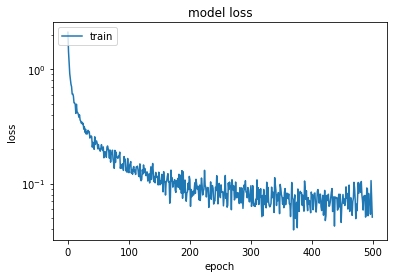

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


ziffer_sortiert_resize\0_0_digit7_20210504-183320.jpg 0 8


ziffer_sortiert_resize\1_D6_2020-08-23_11-50-46.jpg 1 0


ziffer_sortiert_resize\2_4_nt7_20210702-033547.jpg 2 4


ziffer_sortiert_resize\3_Ziffer_3_0145.jpg 3 -1


ziffer_sortiert_resize\6_10_ht6_20210628-141923.jpg 6 8


ziffer_sortiert_resize\7_D7_2020-08-20_15-23-28.jpg 7 2


ziffer_sortiert_resize\NaN_20200910-153847_ROI5.jpg -1 2


ziffer_sortiert_resize\NaN_20200911-182857_ROI5.jpg -1 3


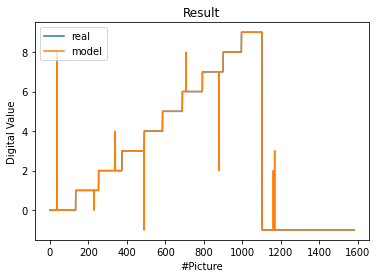

In [6]:
Input_dir='ziffer_sortiert_resize'
res = []
only_deviation = True
show_wrong_image = True

files = glob.glob(Input_dir + '/*.jpg')

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(aktfile)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation == True:
        if str(classes) != str(expected_class):
            print(aktfile + " " + str(expected_class) +  " " + str(classes))
            if show_wrong_image == True:
                display(image_in)
    else:
        print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmphkpdxn0s\assets


219292

In [8]:
FileName = TFliteNamingAndVersion + "q.tflite"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp0zsu6ehb\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp0zsu6ehb\assets


dig1320s3q.tflite


63728

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.